In [1]:
import pickle
from advectionGPdatasets.roundhill import RoundHill,RoundHillModel
from advectionGP.kernels import EQ
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.set_printoptions(precision=1,suppress=True)


In [110]:
def computeSourceDistributionVarianceOnly(self,meanZ,covZ,coords=None):
    """
    Computes the S distribution (at each grid point) using the previously inferred mean and covariance of z. Does not compute joint distribution due to required size of covariance matrix
    Arguments:
        meanZ: an Nfeat long vector inferred using computeZDistribution
        covZ: an Nfeat x Nfeat matrix inferred using computeZDistribution
    """
    
    delta, Ns = self.getGridStepSize()

    if coords is None:
        coords = self.coords
    meanSource = np.zeros(coords.shape[1:])
    varSource = np.zeros(coords.shape[1:])

    Phi = []
    for i,phii in enumerate(self.kernel.getPhi(coords)):
        Phi.append(phii)
        meanSource += meanZ[i]*phii
    Phi = np.array(Phi)
    temp = np.einsum('mlkji,mn->nlkji', Phi, covZ) #TO DO Need to make einsums shape-dims agnostic
    varSource = np.einsum('mlkji,mlkji->ijkl', temp, Phi)
    
    return meanSource, varSource.T

In [111]:
from advectionGPdatasets import proposeboundary
from advectionGP.kernels import EQ
from advectionGP.sensors import FixedSensorModel
from advectionGP.wind import WindSimple
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
        
rh = RoundHill()
X = rh.experiments[0].X
Y = rh.experiments[0].Y
X = np.c_[X,np.ones(len(X))]
boundary = proposeboundary(X)
boundary[0][3]=0
boundary[1][3]=30 #30m up
boundary[0][2]=-30 #puts the source on the grid!
boundary[0][0]=-120 #add two minutes to start
dist = np.round(X[:,2]**2+X[:,3]**2).astype(int)
keep = dist==10000 #2500, 10000, 40000
Xtest = X[keep,:]
Ytest = Y[keep]
X = X[~keep,:]
Y = Y[~keep]

sourcemeans = []
soucevars = []
for samp in range(10):
    k = EQ(np.array([200,3,3,3]), 200)
    sensors = FixedSensorModel(X,3)
    windmodel=WindSimple(rh.experiments[0].windX,rh.experiments[0].windY,0)

    mInfer = Model(resolution=[150,50,50,6],boundary=boundary,N_feat=4000,
                   noiseSD=0.01,kernel=k,sensormodel=sensors,
                   windmodel=windmodel,k_0=0.4,walls=[(3,0,-1)]) 
    mInfer.computeModelRegressors(Nparticles=40) # Compute regressor matrix
    meanZ, covZ = mInfer.computeZDistribution(Y)

    Zs = meanZ[None,:]
    scaleby=[30,1,1,1]
    lowres_coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2],::scaleby[3]]
    coords_transposed = lowres_coords.transpose([1,2,3,4,0])

    tempcoords_transposed = coords_transposed[3:4,:,:,0:1,:]
    testX = tempcoords_transposed.reshape([np.prod(tempcoords_transposed.shape[:-1]).astype(int),4])[:,[0,0,1,2,3]]


    sourcemean,sourcevar = computeSourceDistributionVarianceOnly(mInfer,meanZ,covZ,lowres_coords)
    sourcemeans.append(sourcemean)
    sourcevars.append(sourcevar)

Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done


KeyboardInterrupt: 

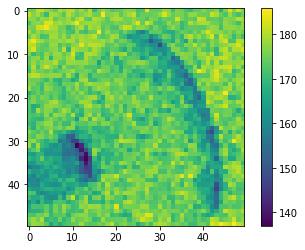

In [48]:
plt.imshow(sourcevar.T[0,:,:,0])
plt.colorbar()

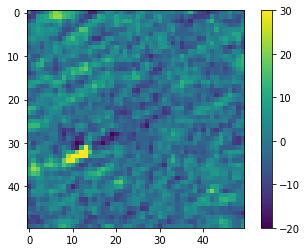

In [66]:
plt.imshow(sourcemean[0,:,:,0],clim=[-20,30])
plt.colorbar()

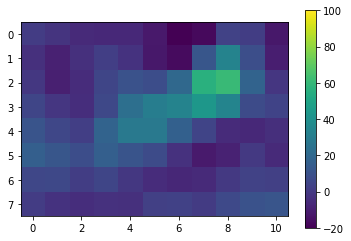

In [96]:
plt.imshow(sourcemean[0,30:38,5:16,0:2],clim=[-20,100])
plt.colorbar()

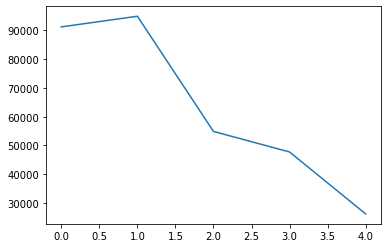

In [109]:
plt.plot(np.sum(sourcemean[:,30:38,5:16,0:2],(1,2,3))*np.prod(mInfer.getGridStepSize()[0][1:]))

In [52]:
regs = mInfer.computeModelRegressors(50,FixedSensorModel(testX,3))

Initialising particles...
Diffusing particles...


In [57]:
regs.shape

(2000, 2500)

In [58]:
meanZ.shape

(2000,)

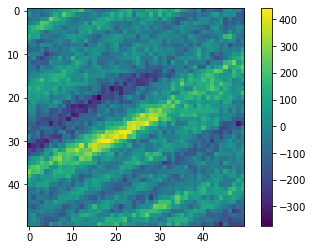

In [59]:
plt.imshow((meanZ@regs).reshape([50,50]))
plt.colorbar()

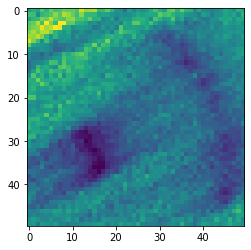

In [60]:
plt.imshow(np.diag(regs.T@covZ@regs).reshape([50,50]))

# ------------------------

In [113]:
Nsamps = 20
Zs_samples = np.random.multivariate_normal(meanZ,covZ+np.eye(len(covZ))*1e-1,Nsamps)
scaleby=[8,1,1,1]
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2],::scaleby[3]].transpose([1,2,3,4,0])
sources_samples = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcesmean = np.mean(sources_samples,0)
sourcesvar = np.var(sources_samples,0)


<ipython-input-113-d3b61f82b7ab>:2: RuntimeWarning: covariance is not positive-semidefinite.
  Zs_samples = np.random.multivariate_normal(meanZ,covZ+np.eye(len(covZ))*1e-1,Nsamps)


In [71]:
concmean.shape

(19, 40, 40, 10)

In [72]:
sourcesmean.shape

(150, 40, 40, 10)

In [101]:
np.prod(mInfer.getGridStepSize()[0][1:])

236.21999999999997

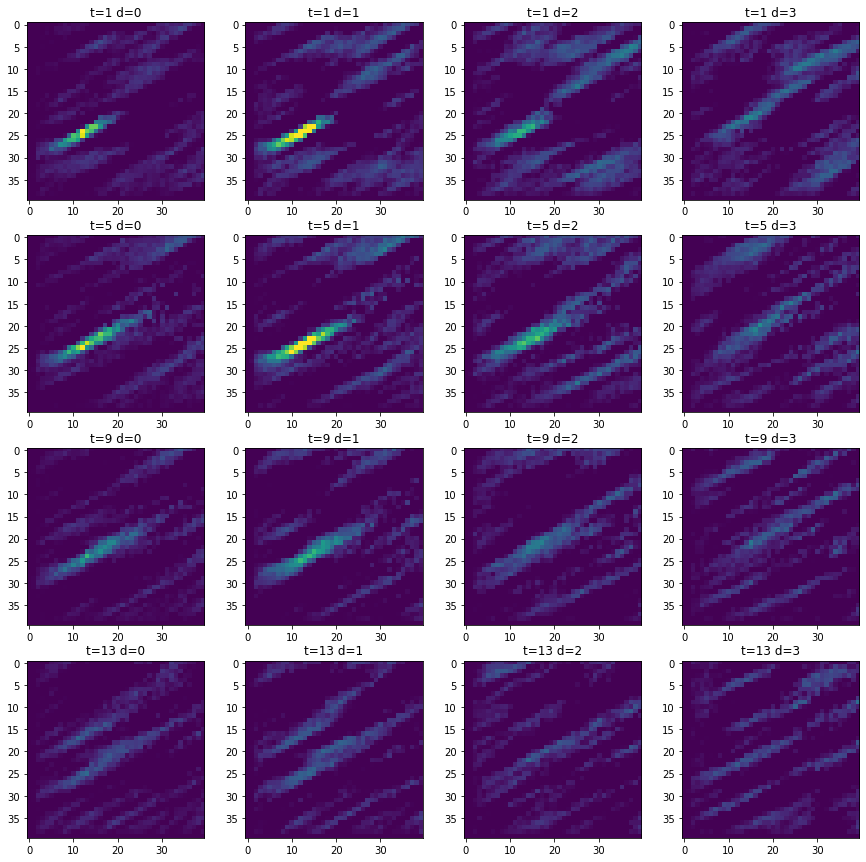

In [86]:
plt.figure(figsize=[15,15])
for ti,t in enumerate(range(1,14,4)):
    for d in range(4):
        plt.subplot(4,4,d+1+ti*4)
        plt.imshow(concmean[t,:,:,d],clim=[0,300])
        plt.title('t=%d d=%d' % (t,d))
#plt.colorbar()

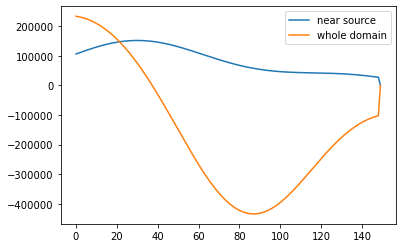

In [94]:
plt.plot(np.sum(sourcesmean[:,23:33,0:15,:3],(1,2,3))*np.prod(mInfer.getGridStepSize()[0][1:]),label='near source')
plt.plot(np.sum(sourcesmean,(1,2,3))*np.prod(mInfer.getGridStepSize()[0][1:]),label='whole domain')
plt.legend()

In [75]:
sourcesmean[:,25:33,0:12,:3].shape

(150, 8, 12, 3)

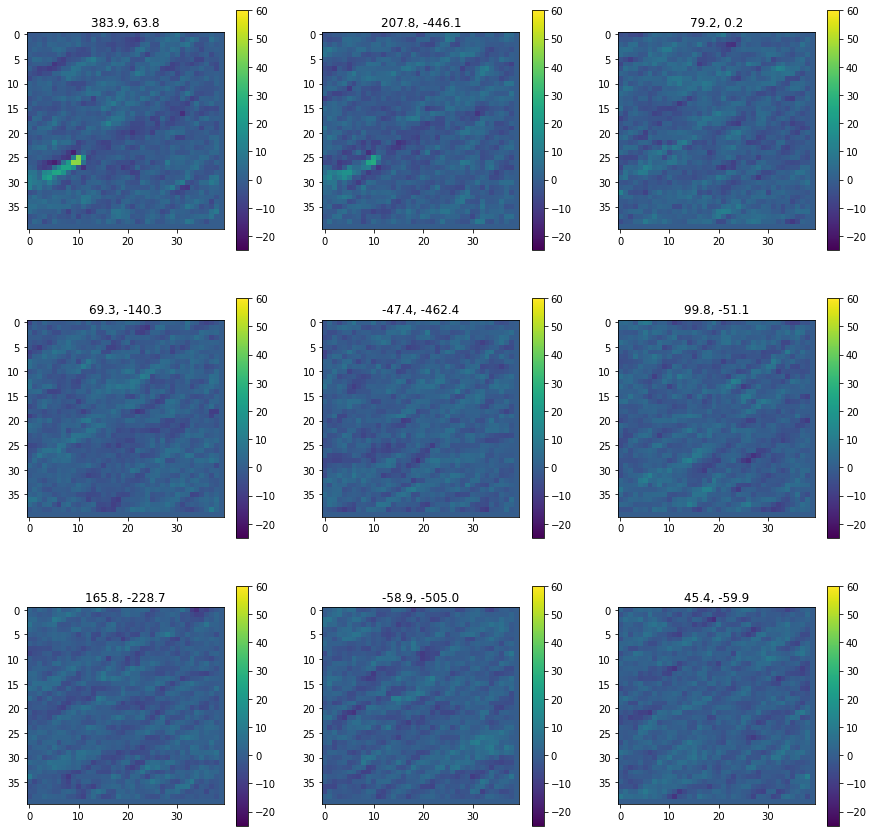

In [98]:
plt.figure(figsize=[15,15])
for d in range(9):
    plt.subplot(3,3,d+1)
    plt.imshow(sourcesmean[9,:,:,d],clim=[-25,60])
    plt.title("%0.1f, %0.1f" % (np.sum(sourcesmean[9,25:33,0:12,d]),np.sum(sourcesmean[90,:,:,d])))
    plt.colorbar()

In [ ]:

class RoundHillModel3d():
    def __init__(self,N_feat=1000,Nparticles=10,k=None,res = [100,30,30,30],noiseSD=0.01,k_0=1):
        """
        This class encapsulates the modelling of the roundhill dataset.
        """
        self.rh = RoundHill()
        self.X = self.rh.experiments[0].X
        self.Y = self.rh.experiments[0].Y #scaling
        self.boundary = proposeboundary(self.X)
        self.boundary[0][2]=-30 #puts the source on the grid!
        self.boundary[0][0]=-120 #add two minutes to start
        dist = np.round(self.X[:,2]**2+self.X[:,3]**2).astype(int)
        self.keep = dist==10000 #2500, 10000, 40000
        self.Xtest = self.X[self.keep,:]
        self.Ytest = self.Y[self.keep]
        self.X = self.X[~self.keep,:]
        self.Y = self.Y[~self.keep]
        self.N_feat = N_feat
        self.Nparticles = Nparticles
        if k is None:
            self.k = EQ(np.array([200,9,9]), 200)
        else:
            self.k = k
        self.res = res
        self.noiseSD = noiseSD
        self.sensors = FixedSensorModel(self.X,3)
        self.windmodel=WindSimple(self.rh.experiments[0].windX,self.rh.experiments[0].windY)
        self.k_0 = k_0
        
        
        self.mInfer = Model(resolution=self.res,boundary=self.boundary,N_feat=self.N_feat,
                       noiseSD=self.noiseSD,kernel=self.k,sensormodel=self.sensors,
                       windmodel=self.windmodel,k_0=self.k_0) 

    def compute(self,Nsamps=1,scaleby=[8,1,1]):
        """
        Compute using the specified model using:
            Nsamps = number of samples [default 1 == the mean of Zs]
            scaleby = the downscaled resolution of the concentration matrix returned [default [8,1,1]]
        Returns a dictionary of:
                sources,
                conc (Concentration),
                testconc (Concentration at test observations).
            Each dictionary contains another dictionary of the:
                mean - of samples
                var - of samples
                all - the raw samples
        """
        self.mInfer.computeModelRegressors(Nparticles=self.Nparticles) # Compute regressor matrix
        meanZ, covZ = self.mInfer.computeZDistribution(self.Y)

        if Nsamps==0:
            return None
        if Nsamps==1:
            Zs = meanZ[None,:]
        else:
            Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
   
        #Compute source grid
        coords = self.mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]].transpose([1,2,3,0])
        sources = np.array([self.mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
        sourcesmean = np.mean(sources,0)
        sourcesvar = np.var(sources,0)

        #compute concentration grid
        concmean,concvar,concentrations = self.mInfer.computeConcentration(Nparticles=self.Nparticles,
                                                                           Zs=Zs,interpolateSource=True,
                                                                           coords=coords)

        #Compute concentrations at test points
        self.gridsource = self.mInfer.getGridCoord(np.array([0,0,0])) #location of ground truth source
        self.gridX = self.mInfer.getGridCoord(self.X[:,1:])/np.array(scaleby) #grid-coords of X (inputs)
        self.mInferCoords = self.mInfer.coords
        self.testsensors = FixedSensorModel(self.Xtest,3)
        particles = self.mInfer.genParticlesFromObservations(50,self.testsensors)
        meantestconc,vartestconc,testconc = self.mInfer.computeConcentration(
                    particles=particles,Zs=Zs,interpolateSource=True)
        self.Zs = Zs
        self.results = {'sources':{'mean':sourcesmean,'var':sourcesvar,'all':sources},
                'conc':{'mean':concmean,'var':concvar,'all':concentrations},
                'testconc':{'mean':meantestconc,'var':vartestconc,'all':testconc}}
        return self.results

In [2]:

#to erase the cache..
#!rm roundhillmodel_cache.pkl
try:
    rhm = pickle.load(open('roundhillmodel_cache3d.pkl','rb'))
    results = rhm.results
except FileNotFoundError:
    k = EQ(np.array([200,5,5,5]), 200)
    rhm = RoundHillModel(N_feat=1000,Nparticles=30,k=k)
    results = rhm.compute(30)
    pickle.dump(rhm,open('roundhillmodel_cache.pkl','wb'))

In [3]:
source_grid_pos = rhm.mInfer.getGridCoord([0,0,0])

/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


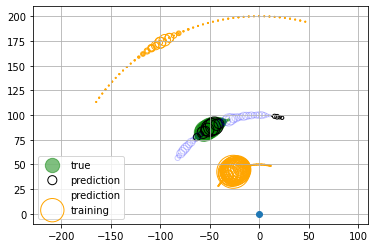

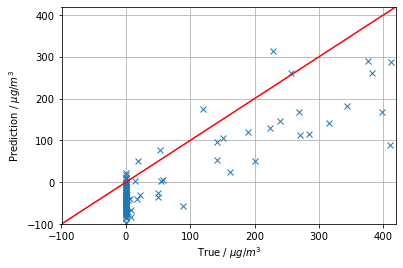

In [8]:
plt.figure()
rhm.plot_test(timepoint=30)
plt.savefig('rhm_plot_test_timepoint30.pdf')
plt.figure()
rhm.scatter_plot_test()
plt.plot([-100,500],[-100,500],'r-')
plt.xlim([-100,420])
plt.ylim([-100,420])
plt.savefig('rhm_scatter_plot_test_timepoint30.pdf')


In [9]:
import GPy
k = GPy.kern.RBF(3,ARD=True,lengthscale=30)
m = GPy.models.GPRegression(rhm.X,rhm.Y[:,None],k)
m.Gaussian_noise = 2.0
#m.optimize()
m.kern.lengthscale

 /home/mike/Documents/Research/GPy/GPy/core/gp.py:85: UserWarning:Your kernel has a different input dimension 3 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


index,GP_regression.rbf.lengthscale,constraints,priors
[0],30.0,+ve,
[1],30.0,+ve,
[2],30.0,+ve,


 /home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning:invalid value encountered in sqrt
 /home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning:invalid value encountered in sqrt


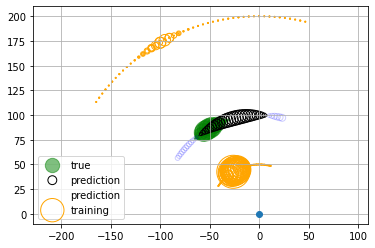

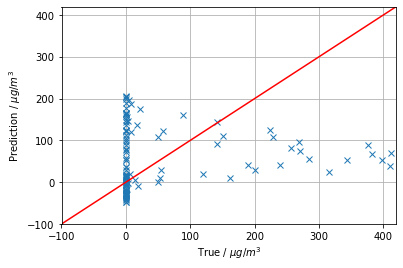

In [11]:
GPpreds, GPvars = m.predict(rhm.Xtest)
plt.figure()
rhm.plot_test(GPpreds,30)
plt.savefig('rhm_GP_plot_test_timepoint30.pdf')
plt.figure()
rhm.scatter_plot_test(GPpreds)
plt.plot([-100,500],[-100,500],'r-')
plt.xlim([-100,420])
plt.ylim([-100,420])

plt.savefig('rhm_GP_scatter_plot_test_timepoint30.pdf')


In [12]:
rhm.compute_RMSE()

847.2876380867098

In [13]:
def MAE(a):
    return np.mean(np.abs(a))
def RMSE(a):
    return np.sqrt(np.mean(a**2))
def MSE(a):
    return np.mean(a**2)

print(" Time     GP   Adjoint")
for t in [30,180,600]:
    keep = rhm.Xtest[:,1]==t
    thresholdGPpreds = GPpreds.copy()
    thresholdGPpreds[thresholdGPpreds<0]=0
    thresholdpreds = rhm.results['testconc']['mean'].copy()
    thresholdpreds[thresholdpreds<0]=0
    print("%5d: %6.0f %6.0f" % (t,MSE(rhm.Ytest[keep]-thresholdGPpreds[keep,0]),MSE(rhm.Ytest[keep]-thresholdpreds[keep])))

 Time     GP   Adjoint
   30:  21385   5533
  180:  12968   1926
  600:   8490   3131


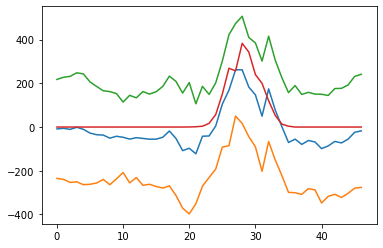

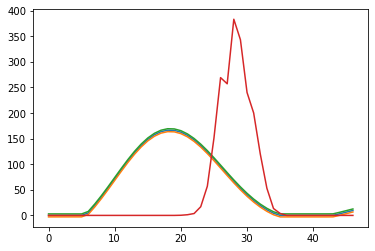

In [14]:
keep = rhm.Xtest[:,1]==180
plt.plot(results['testconc']['mean'][keep]);
plt.plot(results['testconc']['mean'][keep]-2*np.sqrt(results['testconc']['var'][keep]));
plt.plot(results['testconc']['mean'][keep]+2*np.sqrt(results['testconc']['var'][keep]));
plt.plot(rhm.Ytest[keep])
plt.figure()
plt.savefig('rhm_plot_pred_slice_time180.pdf')
plt.plot(thresholdGPpreds[keep])
plt.plot(thresholdGPpreds[keep]-2*np.sqrt(GPvars[keep]))
plt.plot(thresholdGPpreds[keep]+2*np.sqrt(GPvars[keep]))
plt.plot(rhm.Ytest[keep])
plt.savefig('rhm_plot_GP_pred_slice_time180.pdf')

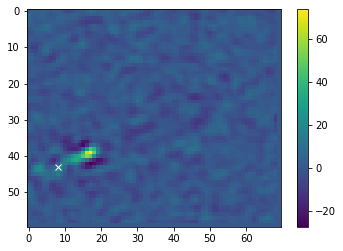

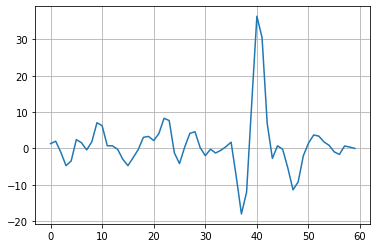

In [16]:
plt.imshow(results['sources']['mean'][30,:,:])
plt.colorbar()
plt.plot(source_grid_pos[2],source_grid_pos[1],'wx')
plt.savefig('rhm_source_plot.pdf')
plt.figure()
plt.plot(results['sources']['mean'][30,:,14])
plt.grid()
plt.savefig('rhm_source_plot_slice.pdf')

# Non-negative

In [17]:
from advectionGP.kernels import meshgridndim
from advectionGP.constraints import NonNegConstraint

top,bottom = np.array([-60., -70.,  -30.]), np.array([200.,  68, 60])
Xnonneg = meshgridndim([top,bottom],17,True)
nnc = NonNegConstraint(rhm.mInfer,rhm.Y,Xnonneg,thinning=10,jitter=1e-4,verbose=True,burnin=50,usecaching=False)#,startpointnormalised=True)
samps = nnc.sample(20) #spare start point makes it overly smooth etc

Computing mean and covariance of Z distribution
Computing SS...
Inverting SS...
Computing meanZ
Done
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
  249/  250 [samples]


In [18]:
import pickle
pickle.dump(samps,open('nnsamps.pkl','wb'))

In [19]:
#dill.dump([nnc,samps,Xnonneg,top,bottom],open('nonneg.pkl','wb'))

In [20]:
planes = np.array([phi for phi in rhm.mInfer.kernel.getPhi(Xnonneg.T)])
np.all(planes.T @ samps.T>0)

True

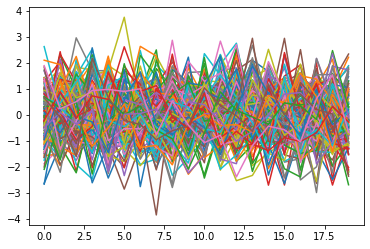

In [21]:
plt.plot(samps[:,::60]-np.mean(samps[:,::60],0));

In [22]:
sourcesNoNeg = np.array([rhm.mInfer.computeSourceFromPhiInterpolated(z) for z in samps])
import pickle
pickle.dump(sourcesNoNeg,open('nn_sources.pkl','wb'))

cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...


In [23]:
particles = rhm.mInfer.genParticlesFromObservations(50,rhm.testsensors)
meantestconc,vartestconc,testconc = rhm.mInfer.computeConcentration(
            particles=particles,Zs=samps,interpolateSource=True)

pickle.dump([meantestconc,vartestconc,testconc],open('nn_conc','wb'))

Initialising particles...
Particle shape:
(50, 117, 3)
Diffusing particles...


In [24]:
testconc.shape

(20, 117)

In [25]:
rhm.compute_RMSE()

847.2876380867098

In [26]:
rhm.compute_RMSE(meantestconc)

5954.365911673481

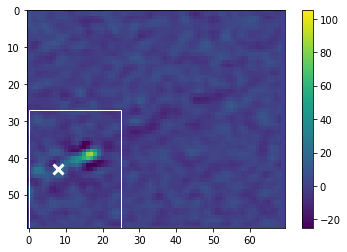

In [61]:

gridCoordsXnonneg = rhm.mInfer.getGridCoord(Xnonneg)
gridEdgeNonNeg = np.array([np.min(gridCoordsXnonneg,0),np.max(gridCoordsXnonneg,0)]) #rhm.mInfer.getGridCoord([top,bottom])
plt.imshow(rhm.results['sources']['mean'][11,:,:])
plt.colorbar()
plt.plot(source_grid_pos[2],source_grid_pos[1],'xw',markersize=10,mew=3)
#plt.plot(gridCoordsXnonneg[:,2],gridCoordsXnonneg[:,1],'.b',markersize=1)
#plt.clim([0,40])
plt.vlines(gridEdgeNonNeg[:,2],gridEdgeNonNeg[0,1],gridEdgeNonNeg[1,1],'w',lw=1)
plt.hlines(gridEdgeNonNeg[:,1],gridEdgeNonNeg[0,2],gridEdgeNonNeg[1,2],'w',lw=1)
plt.ylim([59,0])
plt.clim([-25,105])
plt.savefig('rhm_source_plot_again.pdf')

 /home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning:invalid value encountered in sqrt


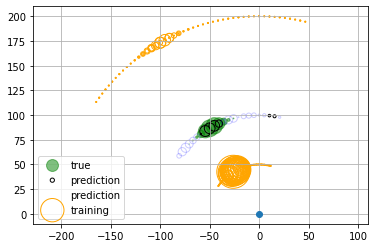

In [30]:
rhm.plot_test()
plt.savefig('rhm_plot_test_normal.pdf')

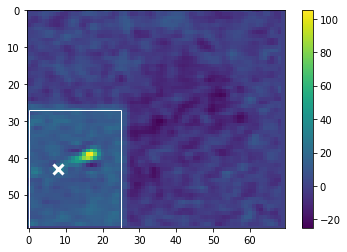

In [60]:

gridCoordsXnonneg = rhm.mInfer.getGridCoord(Xnonneg)
gridEdgeNonNeg = np.array([np.min(gridCoordsXnonneg,0),np.max(gridCoordsXnonneg,0)]) #rhm.mInfer.getGridCoord([top,bottom])
plt.imshow(np.mean(sourcesNoNeg,0)[11,:,:])
plt.colorbar()
plt.plot(source_grid_pos[2],source_grid_pos[1],'xw',markersize=10,mew=3)
#plt.plot(gridCoordsXnonneg[:,2],gridCoordsXnonneg[:,1],'.b',markersize=1)
#plt.clim([0,40])
plt.vlines(gridEdgeNonNeg[:,2],gridEdgeNonNeg[0,1],gridEdgeNonNeg[1,1],'w',lw=1)
plt.hlines(gridEdgeNonNeg[:,1],gridEdgeNonNeg[0,2],gridEdgeNonNeg[1,2],'w',lw=1)
plt.ylim([59,0])
plt.clim([-25,105])
plt.savefig('rhm_source_plot_NONEG.pdf')

(27, 59)

 <ipython-input-59-81e06c7007ac>:8: MatplotlibDeprecationWarning:The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
 <ipython-input-59-81e06c7007ac>:8: MatplotlibDeprecationWarning:The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


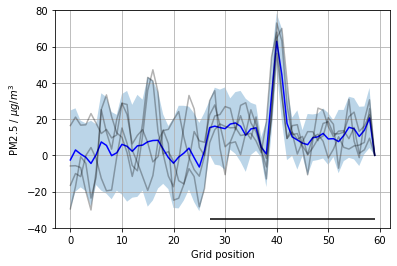

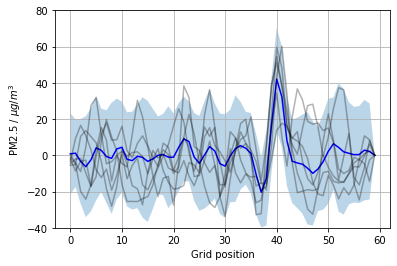

In [59]:
#plot slices
for fn,data in zip(['nonneg','normal'],[sourcesNoNeg,rhm.results['sources']['all']]):
    plt.figure()
    s = np.std(data[:,11,:,14],0)
    m = np.mean(data[:,11,:,14],0)
    plt.plot(np.arange(60),m,'b');
    plt.plot(np.arange(60),data[::5,11,:,14].T,'k',alpha=0.3);
    plt.fill_between(np.arange(60),m-1.96*s,m+1.96*s,'b',alpha=0.3);
    plt.xlabel('Grid position')
    plt.ylabel('PM2.5 / $\mu g/m^3$')
    plt.ylim([-40,80])
    plt.grid()
    if fn=='nonneg':
        plt.hlines(-35,gridEdgeNonNeg[0,1],gridEdgeNonNeg[1,1])
    plt.savefig('slice'+fn+'.pdf')

 /home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning:invalid value encountered in sqrt
 /home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning:invalid value encountered in sqrt


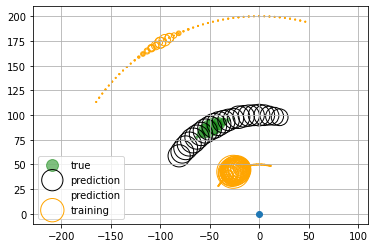

In [29]:
rhm.plot_test(meantestconc)
plt.savefig('rhm_plot_test_noneg.pdf')

# Experimental: Marginal Likelihood

In [4]:
rhm.mInfer.coords.T.shape

(70, 60, 100, 3)

In [11]:
meanZ, covZ=rhm.mInfer.computeZDistribution(rhm.Y)

Computing SS...
Inverting SS...
Computing meanZ
Done


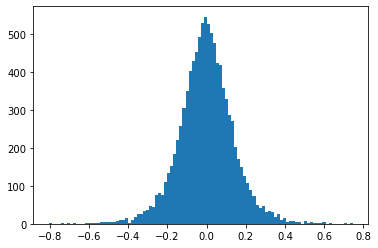

In [20]:
plt.hist(meanZ,100);

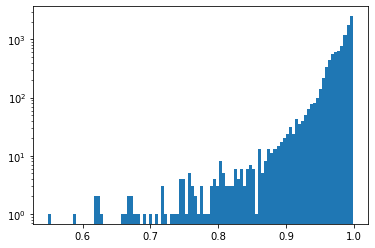

In [16]:
plt.hist(np.diag(covZ),100,log=True);

In [31]:
np.max(mat)

0.2460316096952032

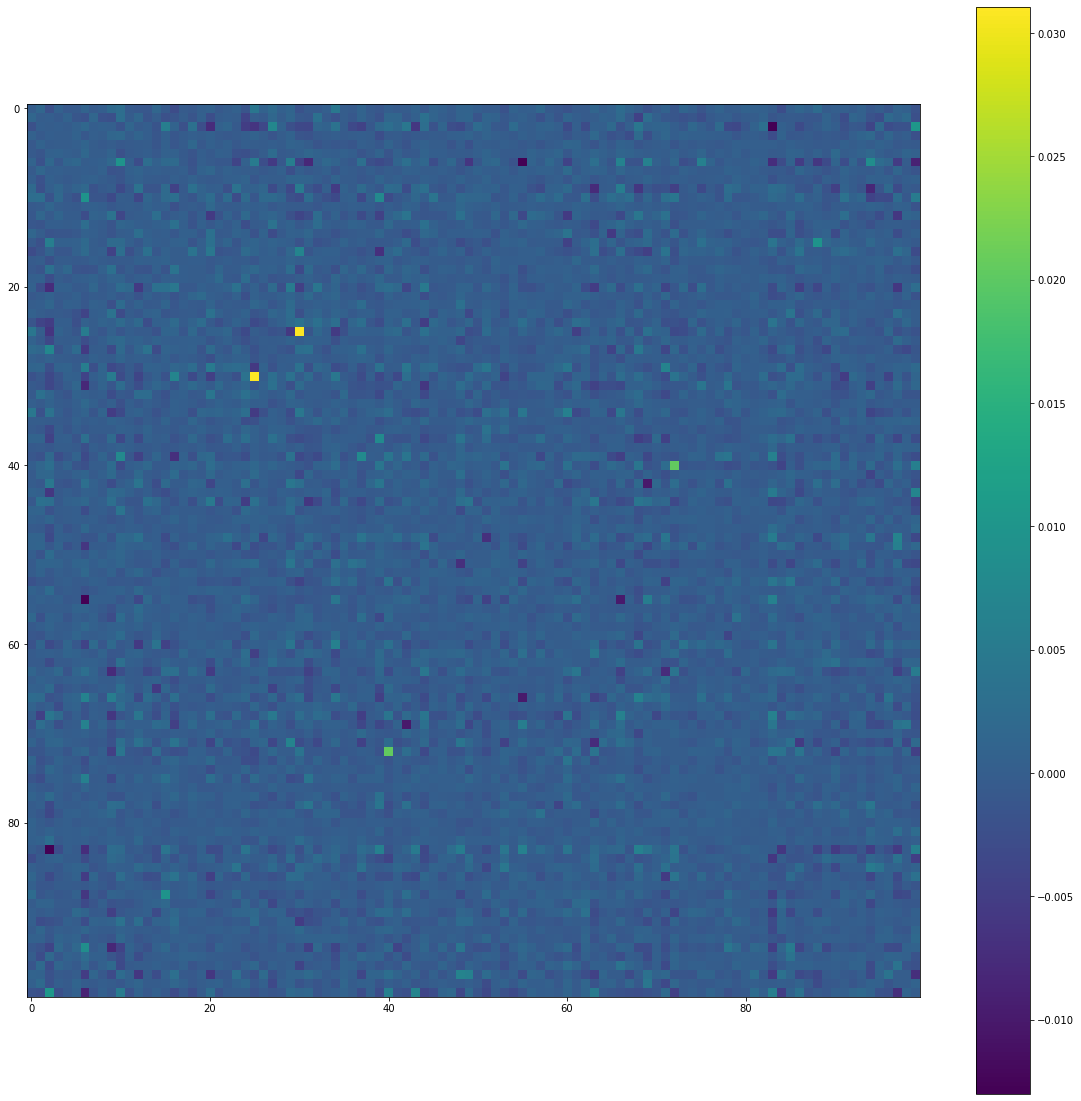

In [30]:
plt.figure(figsize=[20,20])
mat = covZ-np.diag(np.diag(covZ))
plt.imshow(((mat[:100,:100])))
plt.colorbar()

In [16]:
from scipy.stats import multivariate_normal as mvn

for ls in [6,7]:
    k = EQ(np.array([200,ls,ls]), 200)
    rhmTest = RoundHillModel(N_feat=7000,Nparticles=10,k=k)
    results = rhmTest.compute(0)
    cov = rhmTest.mInfer.X.T @ rhmTest.mInfer.X + rhmTest.mInfer.noiseSD**2 * np.eye(rhmTest.mInfer.X.shape[1])
    print(ls,mvn.logpdf(rhmTest.Y,cov=cov))

Initialising particles...
Diffusing particles...


KeyboardInterrupt: 